# **Learning the Vision Transformer**

**By: Brandon Viaje**

## **Project Overview**

The purpose of this project is to reinforce my understanding of the Vision Transformer. While I already have a solid foundation in convolutional neural networks (CNNs), transformers for natural language processing (NLP), and other deep learning techniques, exploring ViTs helps me bridge these concepts and see how transformer architectures can be effectively applied to computer vision tasks.

This project is a combination of following tutorials, reading research papers, and experimenting hands-on to deepen my grasp of how Vision Transformers work and their practical applications.

## **What is a Vision Transformer?**

The vision transformer is a tool used in computer vision that has aided in generative modelling, classification and image detection. ViT's are used in different fields such as the medical and generatiive AI field. What makes ViTs special is that it follows the transformer architecture like you would see in NLP. ViTs use this architecture in a similar way but with images. ViT uses multi headed attention layers which provide a better understanding for long-term and short-term patterns.

<img src="https://images.seattletimes.com/wp-content/uploads/2016/06/7a753b42-29b3-11e6-9ea3-af6d509221b4.jpg?d=1560x1034" width = "500"/>



# Vision Transformer Architecture Overview

I'll walk through the three core segments of the Vision Transformer — **Patch Embedding**, **Transformer Encoder**, and **MLP Classification** — at a high level, without diving too deep into the technical details.

<img src="https://framerusercontent.com/images/erw4zzdu1g2Sb0lh2oL0KhhsgDM.gif" alt="ViT Diagram" width="600"/>

---

### **Patch Embedding**

The first step in the Vision Transformer is to split the input image into fixed-size, non-overlapping **patches**. Each patch is then flattened and mapped into a vector — forming a sequence of patch embeddings in the shape of `(batch size, number of patches, embedding dimension)`.

We also prepend a special **CLS token**, which will later be used for classification, and add **positional embeddings** to retain contextual information that would otherwise be lost.

---

### **Transformer Encoder**

This is the core of the Vision Transformer. The **Transformer Encoder** processes the patch embeddings using **multi-head self-attention**, which allows the model to capture both **local and global relationships** across the image.

Different attention heads focus on different regions or features, helping the model develop a deeper, richer understanding of the image as a whole.

---

### **MLP Head (Classification)**

Finally, we pass only the **CLS token**, now containing information gathered from the entire image — through a **Multi-Layer Perceptron (MLP)** to make the final **classification**.

---


# **Training Dataset**

In this implementation, we use the **MNIST dataset** to train our Vision Transformer. MNIST images are grayscale and have a fixed size of **28×28**, which makes them a convenient choice for prototyping.

Because the images are grayscale, each patch has only **1 channel**, which directly impacts the **embedding dimension**. If we were working with **RGB images**, this value would be **3 channels per patch**, resulting in a larger input dimension for the patch embeddings.

MNIST is also commonly used in many ViT implementations due to its simplicity and low computational requirements, making it ideal for testing and experimenting with model architectures.


<img src="https://datasets.activeloop.ai/wp-content/uploads/2019/12/MNIST-handwritten-digits-dataset-visualized-by-Activeloop.webp" width="400"/>

*MNIST Dataset*

# Implementation/Data Preparation

In [ ]:
# Import Libraries
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.utils.data as dataloader
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Transformation of PIL data into tensor format
transform_operation = transforms.Compose([transforms.ToTensor()])

In [ ]:
# Get PIL Data
train_set = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform= transform_operation )
validation_set = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform= transform_operation )

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.32MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 155kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.82MB/s]


In [ ]:
# Define variables
epochs = 5
batch_size = 64
classes = 10
channels = 1
img_size = 28
patch_size = 7
patch_num = (img_size // patch_size) * (img_size // patch_size)
attention_heads = 4
embedding_dimension = 20
transformer_blocks = 8
MLP_nodes = 64
learning_rate = 0.001

In [ ]:
# Prepare data for the neural network
train_data = dataloader.DataLoader(train_set, shuffle = True, batch_size = batch_size)
validation_data = dataloader.DataLoader(validation_set, shuffle = True, batch_size = batch_size)

# **Patch Embedding**

In this section, we want to compress the 2D image into a **sequence of flattened patch embeddings**. This transformation allows us to treat the image like a sequence, similar to how words are treated in NLP so that it can be processed by the Transformer.

We achieve this by using a `Conv2d` layer where both the kernel size and stride are equal to the patch size. This splits the image into non-overlapping patches and projects each one into a higher-dimensional embedding space. (Shoutout to Linear Algebra)


> **Final output shape:** `(batch_size, num_patches, embedding_dimension)`, ready to be fed into the Transformer encoder.

In [ ]:
# Patch Embedding Portion

class PatchEmbedding(nn.Module):
  def __init__(self):
      super().__init__()
      self.patch_embed = nn.Conv2d(channels, embedding_dimension, kernel_size = patch_size, stride = patch_size)

  def forward(self,x):
    x = self.patch_embed(x)
    x = x.flatten(2).transpose(1,2)
    return x

# Transformer Encoder

This section is where the **Transformer Encoder** occurs. It consists of multiple parts:

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSEpn1EQ1HkEvhOnU5FTjjpxf7kj_5kqejVAQ&s" alt="transformer encoder" width="200"/>


- Two layer normalization steps for stabilizing and speeding up training.
- A multi-head attention layer that runs in parallel; you can experiment with the number of heads (I used 4 here).
- Two residual connections to help with gradient flow and to prevent vanishing gradients.
- A multi layer perceptron block for further feature transformation.
- The activation function I chose is **GELU**, which provides smoother activations compared to ReLU.

<img src="https://www.researchgate.net/publication/370116538/figure/fig3/AS:11431281358801951@1744047564756/Comparison-of-the-ReLu-and-GeLu-activation-functions-ReLu-is-simpler-to-compute-but.tif" alt="relu vs gelu" width="400"/>

I will be running the Transformer Encoder **in series four times**, but I have played around with the number of transformer blocks. I noticed that increasing the number of blocks generally improves performance by allowing the model to capture more complex patterns, but after a certain point, it can lead to overfitting or diminishing returns, especially on smaller datasets like MNIST.



In [ ]:
# Transformer Encoder Portion
# Layer Normalization
# Multi-Head Attention
# Layer Normalization
# Residuals
# MLP - Activation Function (ReLu/GeLu)

class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embedding_dimension)
    self.multi_head_attention = nn.MultiheadAttention(embedding_dimension, attention_heads, batch_first=True)
    self.layer_norm2 = nn.LayerNorm(embedding_dimension)
    self.MLP = nn.Sequential(nn.Linear(embedding_dimension, MLP_nodes), nn.GELU(), nn.Linear(MLP_nodes, embedding_dimension))

  def forward(self,x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.multi_head_attention(x,x,x)[0] + residual1
    residual2 = x
    x = self.layer_norm2(x)
    x = self.MLP(x) + residual2
    return x


# MLP Head

In [ ]:
# MLP Head for Classification
class MLP_Head(nn.Module):
  def __init__(self):
    super().__init__()
    # Classifier, normalize to prevent overfitting
    self.mlp_head = nn.Sequential(nn.LayerNorm(embedding_dimension),nn.Linear(embedding_dimension,classes))

  def forward(self,x):
    return self.mlp_head(x)

# Vision Transformer

In [ ]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = PatchEmbedding()
    self.CLS_token = nn.Parameter(torch.randn(1,1,embedding_dimension))
    self.position_embedding = nn.Parameter(torch.randn(1,patch_num+1,embedding_dimension))
    self.transformer_blocks = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)]) # ADDING TRANSFORMER BLOCKS IN SERIES
    self.MLP_head = MLP_Head()

  def forward(self,x):
    x = self.patch_embedding(x)
    batch_size = x.size(0)
    CLS_tokens = self.CLS_token.expand(batch_size,-1,-1)

    # Append CLS token and position embedding
    x = torch.cat((CLS_tokens,x),dim=1)
    x = x + self.position_embedding
    x = self.transformer_blocks(x)

    # Parse CLS token for classification
    x = x[:,0]

    x = self.MLP_head(x)
    return x

# **Training the ViT**

This section is the training loop for the Vision Transformer model using the MNIST dataset. It includes model initialization, loss function and optimizer setup, and trains the model over multiple epochs while tracking both loss and accuracy. I also experimented with different learning rates and epoch values to observe their impact on performance.



In [ ]:
# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)

# Optimizer - Adam
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# CrossEntropy
criterion = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_epoch = 0
    total_epoch = 0

    print(f"\nEpoch {epoch+1}/{epochs}")

    for batch_idx, (images, labels) in enumerate(train_data):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct = (preds == labels).sum().item()

        correct_epoch += correct
        total_epoch += labels.size(0)

        if batch_idx % 100 == 0:
            batch_acc = 100.0 * correct / labels.size(0)
            print(f"  Batch {batch_idx}: Loss = {loss.item():.4f}, Accuracy = {batch_acc:.2f}%")

    epoch_acc = 100.0 * correct_epoch / total_epoch
    avg_loss = total_loss / len(train_data)

    print(f"==> Epoch {epoch+1} Summary: Avg Loss = {avg_loss:.4f}, Accuracy = {epoch_acc:.2f}%")


Epoch 1/5
  Batch 0: Loss = 2.3733, Accuracy = 7.81%
  Batch 100: Loss = 1.2406, Accuracy = 62.50%
  Batch 200: Loss = 0.6894, Accuracy = 84.38%
  Batch 300: Loss = 0.2949, Accuracy = 93.75%
  Batch 400: Loss = 0.2658, Accuracy = 95.31%
  Batch 500: Loss = 0.4122, Accuracy = 85.94%
  Batch 600: Loss = 0.3167, Accuracy = 90.62%
  Batch 700: Loss = 0.1157, Accuracy = 96.88%
  Batch 800: Loss = 0.2805, Accuracy = 90.62%
  Batch 900: Loss = 0.1520, Accuracy = 95.31%
==> Epoch 1 Summary: Avg Loss = 0.5763, Accuracy = 81.83%

Epoch 2/5
  Batch 0: Loss = 0.2107, Accuracy = 95.31%
  Batch 100: Loss = 0.2315, Accuracy = 93.75%
  Batch 200: Loss = 0.2402, Accuracy = 93.75%
  Batch 300: Loss = 0.1810, Accuracy = 93.75%
  Batch 400: Loss = 0.0781, Accuracy = 96.88%
  Batch 500: Loss = 0.1552, Accuracy = 95.31%
  Batch 600: Loss = 0.0639, Accuracy = 98.44%
  Batch 700: Loss = 0.1615, Accuracy = 96.88%
  Batch 800: Loss = 0.1007, Accuracy = 98.44%
  Batch 900: Loss = 0.1470, Accuracy = 95.31%
==> E

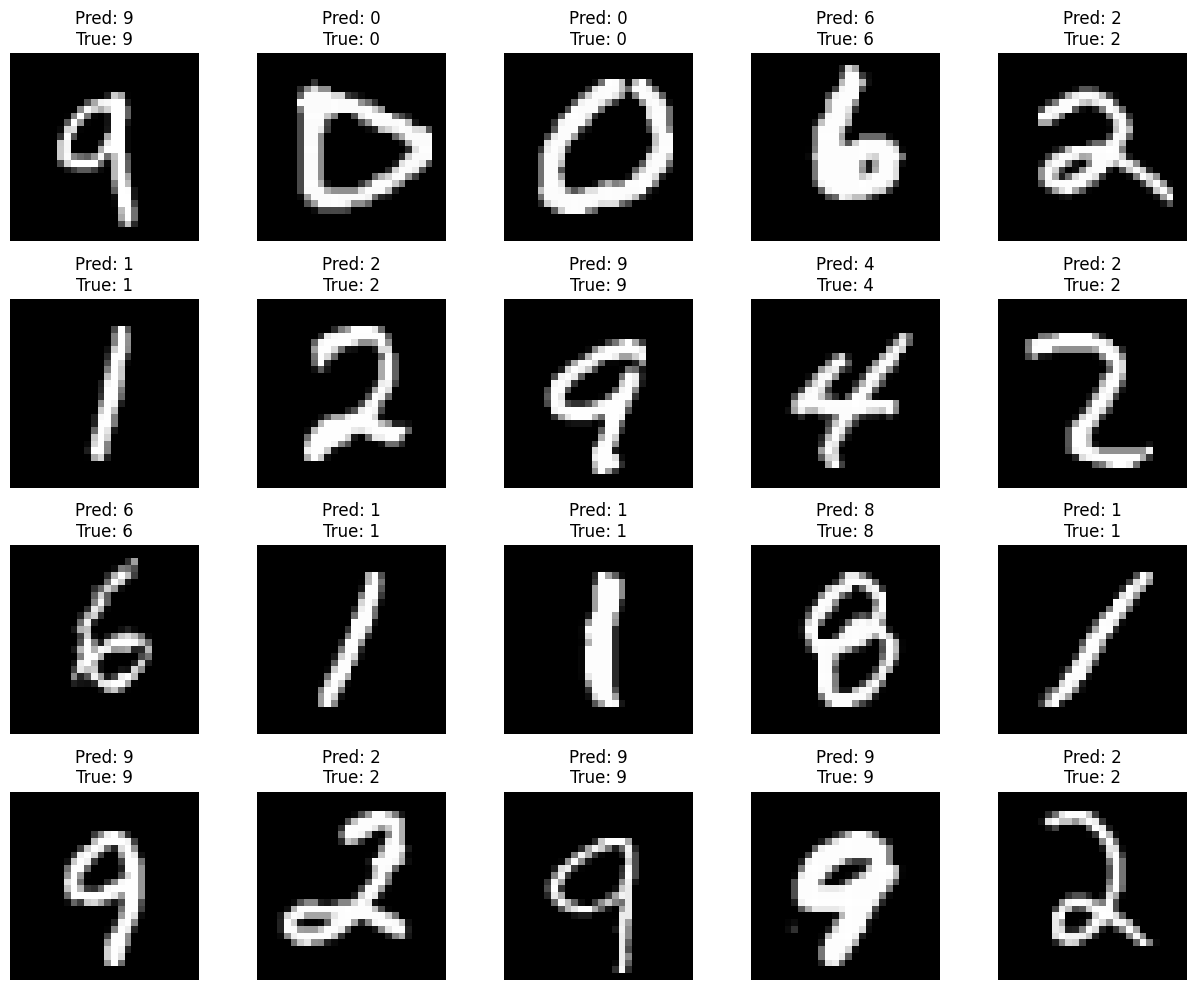

In [ ]:
def mnist_predictions(model, dataloader, device, num_images=20, rows=4, cols=5):
    model.eval()
    images, labels = next(iter(dataloader))
    images, labels = images.to(device), labels.to(device)

    with torch.no_grad():
        outputs = model(images)
        preds = outputs.argmax(dim=1)

    plt.figure(figsize=(cols * 2.5, rows * 2.5))
    for i in range(num_images):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i].squeeze().cpu(), cmap='gray')
        plt.title(f"Pred: {preds[i].item()}\nTrue: {labels[i].item()}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

mnist_predictions(model, validation_data, device)

## **Citations**
**[1]** Deng, L. (2012). *The MNIST database of handwritten digit images for machine learning research*. IEEE Signal Processing Magazine, 29(6), 141–142.

**[2]** Dosovitskiy, A., Beyer, L., Kolesnikov, A., Weissenborn, D., Zhai, X., Unterthiner, T., Dehghani, M., Minderer, M., Heigold, G., Gelly, S., Uszkoreit, J., & Houlsby, N. (2020). *An image is worth 16x16 words: Transformers for image recognition at scale*. arXiv. https://arxiv.org/abs/2010.11929

**[3]** Roboflow Blog. (2025, April 17). *Vision Transformers explained: The future of computer vision?* https://blog.roboflow.com/vision-transformers/

**[4]** V7 Labs. (n.d.). *Vision Transformer: What it is & how it works [2024 guide]*. https://www.v7labs.com/blog/vision-transformer-guide

**[5]**Vizuara. (2022, June 25). Coding a Vision Transformer from scratch using PyTorch [Video]. YouTube. https://www.youtube.com/watch?v=DdsVwTodycw